<a href="https://colab.research.google.com/github/AhsanRaza-dev/Avdvance_Deep_Learning/blob/master/final_hiar_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enter your Kaggle Username: ahsanrazadev\
Enter your Kaggle Key: ··········


100%|██████████| 564M/564M [00:24<00:00, 24.2MB/s]

Extracting files...


🚀 Downloading negative samples (Humans & Vehicles)...


100%|██████████| 6.56M/6.56M [00:01<00:00, 4.92MB/s]

Extracting files...


100%|██████████| 827M/827M [00:40<00:00, 21.7MB/s]

Extracting files...


Found 9850 images belonging to 11 classes.
Found 1275 images belonging to 11 classes.
Found 1275 images belonging to 11 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 186s 558ms/step - accuracy: 0.5111 - loss: 1.5376 - val_accuracy: 0.8855 - val_loss: 0.3788
Epoch 2/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 148s 482ms/step - accuracy: 0.8699 - loss: 0.4094 - val_accuracy: 0.9514 - val_loss: 0.1904
Epoch 3/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 147s 476ms/step - accuracy: 0.9173 - loss: 0.2713 - val_accuracy: 0.9616 - val_loss: 0.1329
Epoch 4/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 146s 474ms/step - accuracy: 0.9389 - loss: 0.2000 - val_accuracy: 0.9702 - val_loss: 0.1099
Epoch 5/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 146s 474ms/step - accuracy: 0.9389 - loss: 0.1896 - val_accuracy: 0.9741 - val_loss: 0.0810
Epoch 6/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 146s 472ms/step - accuracy: 0.9452 - loss: 0.1658 - val_accuracy: 0.9671 - val_loss: 0.1030
Epoch 7/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 144s 467ms/step - accuracy: 0.9534 - loss: 0.1409 - val_accuracy: 0.9663 - val_loss: 0.1103
Epoch 8/20
308/308 ━━━━━━━━━━━━━━━━━━━━ 144s 468ms/step - accuracy: 0.9532 -

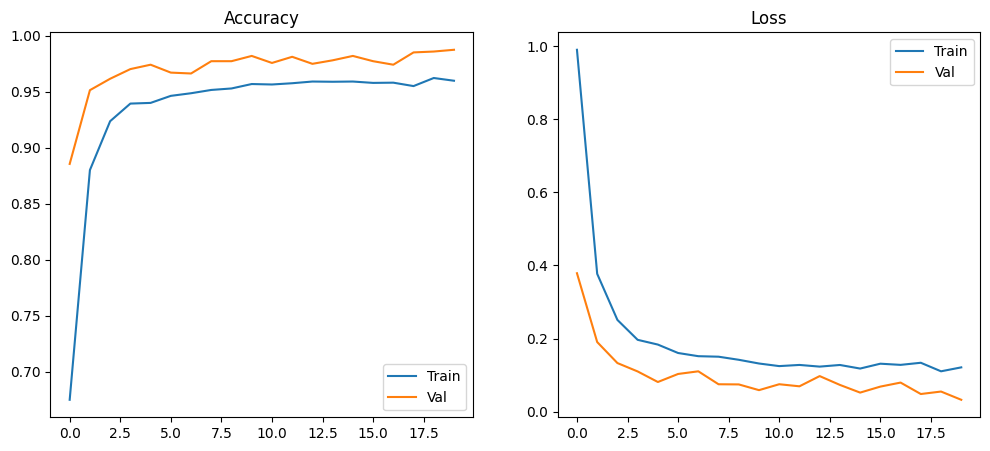

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step

============================== REPORT ==============================
                       precision    recall  f1-score   support

        0_Not_Disease       1.00      0.99      0.99        75
      Alopecia Areata       1.00      1.00      1.00       120
   Contact Dermatitis       0.99      1.00      1.00       120
         Folliculitis       1.00      1.00      1.00       120
            Head Lice       0.98      1.00      0.99       120
        Lichen Planus       0.94      0.97      0.96       120
Male Pattern Baldness       1.00      0.99      1.00       120
            Psoriasis       1.00      1.00      1.00       120
Seborrheic Dermatitis       0.99      0.95      0.97       120
    Telogen Effluvium       1.00      0.99      1.00       120
        Tinea Capitis       0.97      0.97      0.97       120

             accuracy                           0.99      1275
            macro avg       0.99      0.99      0.99      1275
     

In [1]:
import os
import shutil
import kagglehub
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from getpass import getpass
from glob import glob
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# --- 1. DOWNLOAD DATASETS ---
os.environ["KAGGLE_USERNAME"] = input("Enter your Kaggle Username: ")
os.environ["KAGGLE_KEY"] = getpass("Enter your Kaggle Key: ")

# Download Main Hair Disease Dataset
hair_path = kagglehub.dataset_download("sundarannamalai/hair-diseases")
base_path = os.path.join(hair_path, "Hair Diseases - Final")

# --- 2. GENERATE "NOT_DISEASE" DATA (Negative Samples) ---
neg_class_name = "0_Not_Disease"
temp_neg_dir = "temp_negative_samples"
os.makedirs(temp_neg_dir, exist_ok=True)

print("🚀 Downloading negative samples (Humans & Vehicles)...")

# Download Body Parts (for faces/hands)
body_parts_path = kagglehub.dataset_download("linkanjarad/body-parts-dataset")
# Download Vehicles
vehicle_path = kagglehub.dataset_download("mohamedmaher5/vehicle-classification")

def collect_images(source_dir, limit=200):
    collected = []
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                collected.append(os.path.join(root, file))
                if len(collected) >= limit: return collected
    return collected

# Merge into the Not_Disease folder
all_neg_images = collect_images(body_parts_path) + collect_images(vehicle_path)
for i, img_path in enumerate(all_neg_images):
    shutil.copy(img_path, os.path.join(temp_neg_dir, f"neg_{i}.jpg"))

# Distribute Negative samples into Train/Val/Test
for folder in ['train', 'val', 'test']:
    target_dir = os.path.join(base_path, folder, neg_class_name)
    os.makedirs(target_dir, exist_ok=True)
    # Copy a subset to each
    imgs = os.listdir(temp_neg_dir)
    if folder == 'train': subset = imgs[:250]
    elif folder == 'val': subset = imgs[250:325]
    else: subset = imgs[325:]
    for img in subset:
        shutil.copy(os.path.join(temp_neg_dir, img), os.path.join(target_dir, img))

# --- 3. DATA PREPARATION ---
IMAGE_SIZE = [224, 224]
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
val_path = os.path.join(base_path, "val")

train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_path, target_size=IMAGE_SIZE, batch_size=32, class_mode='categorical')
val_set = test_datagen.flow_from_directory(val_path, target_size=IMAGE_SIZE, batch_size=32, class_mode='categorical', shuffle=False)
test_set = test_datagen.flow_from_directory(test_path, target_size=IMAGE_SIZE, batch_size=32, class_mode='categorical', shuffle=False)

# --- 4. BUILD MODEL ---
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

num_classes = len(glob(train_path + '/*'))
x = Flatten()(vgg.output)
x = Dropout(0.5)(x) # Helps prevent overconfidence
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- 5. TRAINING ---
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)
history = model.fit(training_set, validation_data=val_set, epochs=20, callbacks=[checkpoint])

# --- 6. PLOTS & EVALUATION ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plt.plot(history.history['accuracy'], label='Train'); plt.plot(history.history['val_accuracy'], label='Val'); plt.title('Accuracy'); plt.legend()
plt.subplot(1, 2, 2); plt.plot(history.history['loss'], label='Train'); plt.plot(history.history['val_loss'], label='Val'); plt.title('Loss'); plt.legend()
plt.show()

# Classification Report
test_set.reset()
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)
print("\n" + "="*30 + " REPORT " + "="*30)
print(classification_report(test_set.classes, y_pred, target_names=list(test_set.class_indices.keys())))

# --- 7. EXPORT TFLITE FOR FLUTTER ---
model.export("saved_model_v2")
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_v2")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('hair_disease_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Save labels.txt for Flutter Assets
labels = sorted(list(test_set.class_indices.keys()))
with open('labels.txt', 'w') as f:
    for label in labels:
        f.write(label + '\n')

print("\n✅ DONE! 'hair_disease_model.tflite' and 'labels.txt' are ready for Flutter.")